In [7]:
import os

input_dir = "/gsoc/Input/segmented-images/images/"
target_dir = "/gsoc/Input/segmented-images/masks/"
img_size = (96, 96)
num_classes = 1
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1000
/gsoc/Input/segmented-images/images/cju0qkwl35piu0993l0dewei2.jpg | /gsoc/Input/segmented-images/masks/cju0qkwl35piu0993l0dewei2.jpg
/gsoc/Input/segmented-images/images/cju0qoxqj9q6s0835b43399p4.jpg | /gsoc/Input/segmented-images/masks/cju0qoxqj9q6s0835b43399p4.jpg
/gsoc/Input/segmented-images/images/cju0qx73cjw570799j4n5cjze.jpg | /gsoc/Input/segmented-images/masks/cju0qx73cjw570799j4n5cjze.jpg
/gsoc/Input/segmented-images/images/cju0roawvklrq0799vmjorwfv.jpg | /gsoc/Input/segmented-images/masks/cju0roawvklrq0799vmjorwfv.jpg
/gsoc/Input/segmented-images/images/cju0rx1idathl0835detmsp84.jpg | /gsoc/Input/segmented-images/masks/cju0rx1idathl0835detmsp84.jpg
/gsoc/Input/segmented-images/images/cju0s2a9ekvms080138tjjpxr.jpg | /gsoc/Input/segmented-images/masks/cju0s2a9ekvms080138tjjpxr.jpg
/gsoc/Input/segmented-images/images/cju0s690hkp960855tjuaqvv0.jpg | /gsoc/Input/segmented-images/masks/cju0s690hkp960855tjuaqvv0.jpg
/gsoc/Input/segmented-images/images/cju0sr5gh

In [1]:
import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
len(input_img_paths) == len(target_img_paths)

True

In [36]:
## Storing data
X = []
y = []
for image, mask in zip(input_img_paths, target_img_paths):
    X.append(np.array(Image.open(image).resize((96,96))))
    y.append(np.array(Image.open(mask).resize((96,96))))

In [37]:
X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)

X_shape :  (1000, 256, 256, 3)
y_shape :  (1000, 256, 256, 3)


In [9]:
indices = np.random.choice(range(len(input_img_paths)), replace = False ,size = 1000)
train_image_sample = np.array(input_img_paths)[indices]
train_mask_sample = np.array(target_img_paths)[indices]

In [38]:
# Build the dataset.
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [39]:


X = np.empty(shape = (len(indices), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
y = np.empty(shape = (len(indices), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')

for i, (image_path, mask_path) in enumerate(zip(input_img_paths, target_img_paths)):
    image = cv2.imread(image_path, 0)
    mask = cv2.imread( mask_path, 0)
    
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    
    X[i] = image
    y[i] = mask

X = X[:,:,:,np.newaxis] / 255
y = y[:,:,:,np.newaxis] / 255
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (1000, 224, 224, 1)
y shape :  (1000, 224, 224, 1)


In [5]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [40]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [41]:
results = model.fit(X, y, validation_split=0.1, batch_size=4, epochs=1000)

Epoch 1/1000
225/225 [==============================] - 11s 41ms/step - loss: -0.2377 - dice_coef: 0.2377 - val_loss: -0.2838 - val_dice_coef: 0.2838
Epoch 2/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.3291 - dice_coef: 0.3291 - val_loss: -0.4367 - val_dice_coef: 0.4367
Epoch 3/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.4251 - dice_coef: 0.4251 - val_loss: -0.4213 - val_dice_coef: 0.4213
Epoch 4/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.4354 - dice_coef: 0.4354 - val_loss: -0.4377 - val_dice_coef: 0.4377
Epoch 5/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.4392 - dice_coef: 0.4392 - val_loss: -0.4675 - val_dice_coef: 0.4675
Epoch 6/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.4387 - dice_coef: 0.4387 - val_loss: -0.4478 - val_dice_coef: 0.4478
Epoch 7/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.4520 - dice_coef: 0.4520 

Epoch 56/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.5994 - dice_coef: 0.5994 - val_loss: -0.6014 - val_dice_coef: 0.6014
Epoch 57/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.5960 - dice_coef: 0.5960 - val_loss: -0.5981 - val_dice_coef: 0.5981
Epoch 58/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.6067 - dice_coef: 0.6067 - val_loss: -0.6018 - val_dice_coef: 0.6018
Epoch 59/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.6062 - dice_coef: 0.6062 - val_loss: -0.5914 - val_dice_coef: 0.5914
Epoch 60/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.6129 - dice_coef: 0.6129 - val_loss: -0.6021 - val_dice_coef: 0.6021
Epoch 61/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.6066 - dice_coef: 0.6066 - val_loss: -0.6079 - val_dice_coef: 0.6079
Epoch 62/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.6215 - dice_coef: 0

225/225 [==============================] - 9s 40ms/step - loss: -0.7772 - dice_coef: 0.7772 - val_loss: -0.6701 - val_dice_coef: 0.6701
Epoch 111/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.7849 - dice_coef: 0.7849 - val_loss: -0.6479 - val_dice_coef: 0.6479
Epoch 112/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.7908 - dice_coef: 0.7908 - val_loss: -0.6693 - val_dice_coef: 0.6693
Epoch 113/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.7874 - dice_coef: 0.7874 - val_loss: -0.6824 - val_dice_coef: 0.6824
Epoch 114/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.7949 - dice_coef: 0.7949 - val_loss: -0.6739 - val_dice_coef: 0.6739
Epoch 115/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.7879 - dice_coef: 0.7879 - val_loss: -0.6870 - val_dice_coef: 0.6870
Epoch 116/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.7996 - dice_coef: 0.7996 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9007 - dice_coef: 0.9007 - val_loss: -0.6794 - val_dice_coef: 0.6794
Epoch 165/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.8818 - dice_coef: 0.8818 - val_loss: -0.6813 - val_dice_coef: 0.6813
Epoch 166/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.8988 - dice_coef: 0.8988 - val_loss: -0.6752 - val_dice_coef: 0.6752
Epoch 167/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9089 - dice_coef: 0.9089 - val_loss: -0.6815 - val_dice_coef: 0.6815
Epoch 168/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9059 - dice_coef: 0.9059 - val_loss: -0.6843 - val_dice_coef: 0.6843
Epoch 169/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9092 - dice_coef: 0.9092 - val_loss: -0.6768 - val_dice_coef: 0.6768
Epoch 170/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9072 - dice_coef: 0.9072 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9439 - dice_coef: 0.9439 - val_loss: -0.6961 - val_dice_coef: 0.6961
Epoch 219/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9481 - dice_coef: 0.9481 - val_loss: -0.6914 - val_dice_coef: 0.6914
Epoch 220/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9506 - dice_coef: 0.9506 - val_loss: -0.6931 - val_dice_coef: 0.6931
Epoch 221/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9505 - dice_coef: 0.9505 - val_loss: -0.6889 - val_dice_coef: 0.6889
Epoch 222/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9444 - dice_coef: 0.9444 - val_loss: -0.6941 - val_dice_coef: 0.6941
Epoch 223/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9518 - dice_coef: 0.9518 - val_loss: -0.6961 - val_dice_coef: 0.6961
Epoch 224/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9512 - dice_coef: 0.9512 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9686 - dice_coef: 0.9686 - val_loss: -0.7092 - val_dice_coef: 0.7092
Epoch 273/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9673 - dice_coef: 0.9673 - val_loss: -0.7066 - val_dice_coef: 0.7066
Epoch 274/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9673 - dice_coef: 0.9673 - val_loss: -0.7076 - val_dice_coef: 0.7076
Epoch 275/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9649 - dice_coef: 0.9649 - val_loss: -0.7070 - val_dice_coef: 0.7070
Epoch 276/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9658 - dice_coef: 0.9658 - val_loss: -0.7141 - val_dice_coef: 0.7141
Epoch 277/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9684 - dice_coef: 0.9684 - val_loss: -0.7106 - val_dice_coef: 0.7106
Epoch 278/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9602 - dice_coef: 0.9602 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9773 - dice_coef: 0.9773 - val_loss: -0.7159 - val_dice_coef: 0.7159
Epoch 327/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9767 - dice_coef: 0.9767 - val_loss: -0.7130 - val_dice_coef: 0.7130
Epoch 328/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9704 - dice_coef: 0.9704 - val_loss: -0.7129 - val_dice_coef: 0.7129
Epoch 329/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9737 - dice_coef: 0.9737 - val_loss: -0.7132 - val_dice_coef: 0.7132
Epoch 330/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9772 - dice_coef: 0.9772 - val_loss: -0.7149 - val_dice_coef: 0.7149
Epoch 331/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9781 - dice_coef: 0.9781 - val_loss: -0.7115 - val_dice_coef: 0.7115
Epoch 332/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9785 - dice_coef: 0.9785 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9815 - dice_coef: 0.9815 - val_loss: -0.7173 - val_dice_coef: 0.7173
Epoch 381/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9823 - dice_coef: 0.9823 - val_loss: -0.7090 - val_dice_coef: 0.7090
Epoch 382/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9827 - dice_coef: 0.9827 - val_loss: -0.7176 - val_dice_coef: 0.7176
Epoch 383/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9801 - dice_coef: 0.9801 - val_loss: -0.7134 - val_dice_coef: 0.7134
Epoch 384/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9826 - dice_coef: 0.9826 - val_loss: -0.7172 - val_dice_coef: 0.7172
Epoch 385/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9823 - dice_coef: 0.9823 - val_loss: -0.7137 - val_dice_coef: 0.7137
Epoch 386/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9817 - dice_coef: 0.9817 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9853 - dice_coef: 0.9853 - val_loss: -0.7209 - val_dice_coef: 0.7209
Epoch 435/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9852 - dice_coef: 0.9852 - val_loss: -0.7208 - val_dice_coef: 0.7208
Epoch 436/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9847 - dice_coef: 0.9847 - val_loss: -0.7205 - val_dice_coef: 0.7205
Epoch 437/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9856 - dice_coef: 0.9856 - val_loss: -0.7073 - val_dice_coef: 0.7073
Epoch 438/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9847 - dice_coef: 0.9847 - val_loss: -0.7196 - val_dice_coef: 0.7196
Epoch 439/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9845 - dice_coef: 0.9845 - val_loss: -0.7256 - val_dice_coef: 0.7256
Epoch 440/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9728 - dice_coef: 0.9728 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9883 - dice_coef: 0.9883 - val_loss: -0.7262 - val_dice_coef: 0.7262
Epoch 489/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9882 - dice_coef: 0.9882 - val_loss: -0.7221 - val_dice_coef: 0.7221
Epoch 490/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9880 - dice_coef: 0.9880 - val_loss: -0.7244 - val_dice_coef: 0.7244
Epoch 491/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9869 - dice_coef: 0.9869 - val_loss: -0.7280 - val_dice_coef: 0.7280
Epoch 492/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9876 - dice_coef: 0.9876 - val_loss: -0.7275 - val_dice_coef: 0.7275
Epoch 493/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9872 - dice_coef: 0.9872 - val_loss: -0.7271 - val_dice_coef: 0.7271
Epoch 494/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9872 - dice_coef: 0.9872 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9879 - dice_coef: 0.9879 - val_loss: -0.7279 - val_dice_coef: 0.7279
Epoch 543/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9873 - dice_coef: 0.9873 - val_loss: -0.7308 - val_dice_coef: 0.7308
Epoch 544/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9831 - dice_coef: 0.9831 - val_loss: -0.7120 - val_dice_coef: 0.7120
Epoch 545/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9794 - dice_coef: 0.9794 - val_loss: -0.7234 - val_dice_coef: 0.7234
Epoch 546/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9847 - dice_coef: 0.9847 - val_loss: -0.7336 - val_dice_coef: 0.7336
Epoch 547/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9875 - dice_coef: 0.9875 - val_loss: -0.7352 - val_dice_coef: 0.7352
Epoch 548/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9889 - dice_coef: 0.9889 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9852 - dice_coef: 0.9852 - val_loss: -0.7116 - val_dice_coef: 0.7116
Epoch 597/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9652 - dice_coef: 0.9652 - val_loss: -0.7158 - val_dice_coef: 0.7158
Epoch 598/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9849 - dice_coef: 0.9849 - val_loss: -0.7235 - val_dice_coef: 0.7235
Epoch 599/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9877 - dice_coef: 0.9877 - val_loss: -0.7260 - val_dice_coef: 0.7260
Epoch 600/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9889 - dice_coef: 0.9889 - val_loss: -0.7260 - val_dice_coef: 0.7260
Epoch 601/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9892 - dice_coef: 0.9892 - val_loss: -0.7263 - val_dice_coef: 0.7263
Epoch 602/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9896 - dice_coef: 0.9896 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9899 - dice_coef: 0.9899 - val_loss: -0.7343 - val_dice_coef: 0.7343
Epoch 651/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9900 - dice_coef: 0.9900 - val_loss: -0.7346 - val_dice_coef: 0.7346
Epoch 652/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9895 - dice_coef: 0.9895 - val_loss: -0.7390 - val_dice_coef: 0.7390
Epoch 653/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9887 - dice_coef: 0.9887 - val_loss: -0.7374 - val_dice_coef: 0.7374
Epoch 654/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9888 - dice_coef: 0.9888 - val_loss: -0.7343 - val_dice_coef: 0.7343
Epoch 655/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9891 - dice_coef: 0.9891 - val_loss: -0.7372 - val_dice_coef: 0.7372
Epoch 656/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9894 - dice_coef: 0.9894 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9891 - dice_coef: 0.9891 - val_loss: -0.7378 - val_dice_coef: 0.7378
Epoch 705/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9893 - dice_coef: 0.9893 - val_loss: -0.7379 - val_dice_coef: 0.7379
Epoch 706/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9891 - dice_coef: 0.9891 - val_loss: -0.7344 - val_dice_coef: 0.7344
Epoch 707/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9896 - dice_coef: 0.9896 - val_loss: -0.7370 - val_dice_coef: 0.7370
Epoch 708/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9891 - dice_coef: 0.9891 - val_loss: -0.7370 - val_dice_coef: 0.7370
Epoch 709/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9893 - dice_coef: 0.9893 - val_loss: -0.7359 - val_dice_coef: 0.7359
Epoch 710/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9895 - dice_coef: 0.9895 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9897 - dice_coef: 0.9897 - val_loss: -0.7340 - val_dice_coef: 0.7340
Epoch 759/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9903 - dice_coef: 0.9903 - val_loss: -0.7384 - val_dice_coef: 0.7384
Epoch 760/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9899 - dice_coef: 0.9899 - val_loss: -0.7319 - val_dice_coef: 0.7319
Epoch 761/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9898 - dice_coef: 0.9898 - val_loss: -0.7360 - val_dice_coef: 0.7360
Epoch 762/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9894 - dice_coef: 0.9894 - val_loss: -0.7381 - val_dice_coef: 0.7381
Epoch 763/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9897 - dice_coef: 0.9897 - val_loss: -0.7375 - val_dice_coef: 0.7375
Epoch 764/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9901 - dice_coef: 0.9901 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9898 - dice_coef: 0.9898 - val_loss: -0.7366 - val_dice_coef: 0.7366
Epoch 813/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9902 - dice_coef: 0.9902 - val_loss: -0.7392 - val_dice_coef: 0.7392
Epoch 814/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9901 - dice_coef: 0.9901 - val_loss: -0.7386 - val_dice_coef: 0.7386
Epoch 815/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9900 - dice_coef: 0.9900 - val_loss: -0.7365 - val_dice_coef: 0.7365
Epoch 816/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9895 - dice_coef: 0.9895 - val_loss: -0.7384 - val_dice_coef: 0.7384
Epoch 817/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9897 - dice_coef: 0.9897 - val_loss: -0.7369 - val_dice_coef: 0.7369
Epoch 818/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9896 - dice_coef: 0.9896 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9907 - dice_coef: 0.9907 - val_loss: -0.7343 - val_dice_coef: 0.7343
Epoch 867/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9907 - dice_coef: 0.9907 - val_loss: -0.7339 - val_dice_coef: 0.7339
Epoch 868/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9908 - dice_coef: 0.9908 - val_loss: -0.7341 - val_dice_coef: 0.7341
Epoch 869/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9912 - dice_coef: 0.9912 - val_loss: -0.7354 - val_dice_coef: 0.7354
Epoch 870/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9908 - dice_coef: 0.9908 - val_loss: -0.7367 - val_dice_coef: 0.7367
Epoch 871/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9908 - dice_coef: 0.9908 - val_loss: -0.7358 - val_dice_coef: 0.7358
Epoch 872/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9910 - dice_coef: 0.9910 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9898 - dice_coef: 0.9898 - val_loss: -0.7268 - val_dice_coef: 0.7268
Epoch 921/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9886 - dice_coef: 0.9886 - val_loss: -0.7401 - val_dice_coef: 0.7401
Epoch 922/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9904 - dice_coef: 0.9904 - val_loss: -0.7358 - val_dice_coef: 0.7358
Epoch 923/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9905 - dice_coef: 0.9905 - val_loss: -0.7394 - val_dice_coef: 0.7394
Epoch 924/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9908 - dice_coef: 0.9908 - val_loss: -0.7376 - val_dice_coef: 0.7376
Epoch 925/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9902 - dice_coef: 0.9902 - val_loss: -0.7367 - val_dice_coef: 0.7367
Epoch 926/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9909 - dice_coef: 0.9909 - 

225/225 [==============================] - 9s 40ms/step - loss: -0.9908 - dice_coef: 0.9908 - val_loss: -0.7410 - val_dice_coef: 0.7410
Epoch 975/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9906 - dice_coef: 0.9906 - val_loss: -0.7359 - val_dice_coef: 0.7359
Epoch 976/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9898 - dice_coef: 0.9898 - val_loss: -0.7396 - val_dice_coef: 0.7396
Epoch 977/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9904 - dice_coef: 0.9904 - val_loss: -0.7323 - val_dice_coef: 0.7323
Epoch 978/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9904 - dice_coef: 0.9904 - val_loss: -0.7353 - val_dice_coef: 0.7353
Epoch 979/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9899 - dice_coef: 0.9899 - val_loss: -0.7358 - val_dice_coef: 0.7358
Epoch 980/1000
225/225 [==============================] - 9s 40ms/step - loss: -0.9904 - dice_coef: 0.9904 - 

In [12]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = cv2.imread("../input/train/" + X_list[i], 0)
            mask = cv2.imread("../input/train/" + y_list[i], 0)
    
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X[:,:,:,np.newaxis] / 255
        y = y[:,:,:,np.newaxis] / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y    

In [14]:
X_train, X_val, y_train, y_val = train_test_split(input_img_paths, target_img_paths, test_size = 0.3, random_state = 1)

epochs = 10
batch_size = 8
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = Generator(X_train, y_train, batch_size = batch_size)
val_gen = Generator(X_val, y_val, batch_size = batch_size)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [15]:
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs,
                             validation_data = val_gen, validation_steps = validation_steps)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


error: OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()


In [22]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

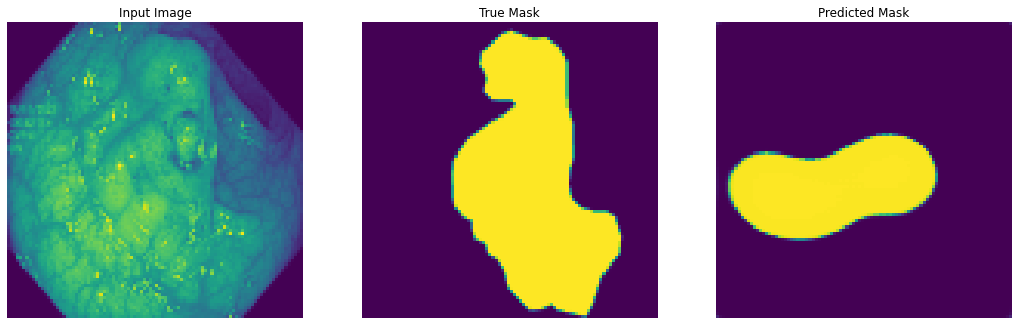

In [34]:
display_sample([X[2],y[2],model.predict(np.array([X[2]])).T[0]])#20 Epochs

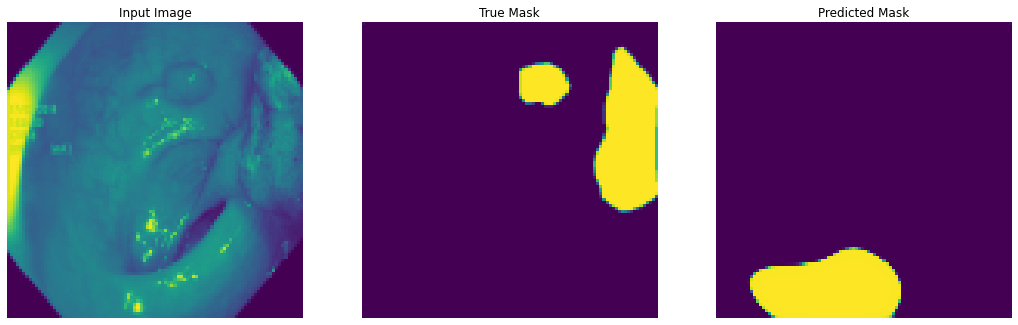

In [37]:
display_sample([X[3],y[3],model.predict(np.array([X[3]])).T[0]])#200 Epochs

In [54]:
.shape

(224, 224, 1)

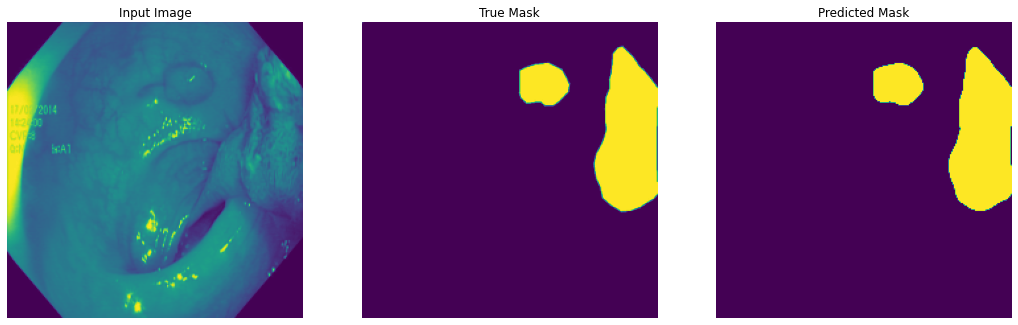

In [55]:
display_sample([X[3],y[3],model.predict(np.array([X[3]]))[0]])# 1000 Epochs

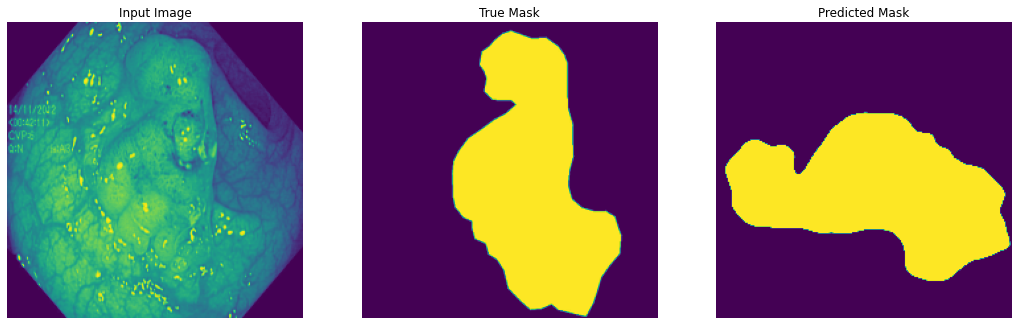

In [43]:
display_sample([X[2],y[2],model.predict(np.array([X[2]])).T[0]])#1000 Epochs